In [68]:
# 패키지 설치
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [75]:
# 이번 과제에 필요한 이전 과제 Factors
iris = datasets.load_iris() # 붓꽃 데이터 가져오기
X = iris.data[:, [2, 3]] # 행은 다 갖고 오고 열은 petal length(2인덱스) 와 petal width(3인덱스)만 가져옴.
y = iris.target # 실제로 맞춰야 하는 값
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1, stratify=y) # 훈련 데이터(70%)와 테스트 데이터(30%)로 나눔,

# 특성 표준화

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train) # 샘플 평균과 표준편차를 계산해서 훈련 세트를 표준화 => 성능 최적화
X_test_std = sc.transform(X_test) # 샘플 평균과 표준편차를 계산해서 테스트 세트를 표준화 => 성능 최적화

# 표준화된 훈련데이터를 사용하여 퍼셉트론 훈련

X_combined_std = np.vstack((X_train_std, X_test_std)) # X_train_std 데이터 아래에 X_test_std 데이터를 붙임.
y_combined = np.hstack((y_train, y_test)) # y_train 데이터 우측에 y_test 데이터를 붙임

# 결정 경계 그래프 함수

def plot_decision_regions(X, y, classifier, test_index = None, resolution= 0.02):
    
    # 마커와 컬러맵을 설정
    markers = ('s', 'x', 'o', '^', 'v') # 마커 설정
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan') # 색깔 설정
    cmap = ListedColormap(colors[:len(np.unique(y))]) # y 레이블 개수에 맞춰 색을 매핑
    
    # 결정 경계(+, -로 구분)
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1 # petal length에 해당하는 최솟값과 최댓값
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1 # petal width에 해당하는 최솟값과 최댓값
    
    # 빈 그래프부분에 그리드 생성
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution)) # 0.2간격의 바둑판 모양으로 x, y축에 최솟값, 최댓값 범위로 생성
    
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T) # xx1과 xx2를 1차원 배열로 변경 후 계단 함수를 돌려서 1과 -1로 구분
    Z = Z.reshape(xx1.shape) # 그렇게 생성된 걸 다시 xx1의 차원 수에 맞춰서 다시 변경
    
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap) # 색으로 구분된 등고선 맵 그리기
    plt.xlim(xx1.min(), xx1.max()) # x 축 설정
    plt.ylim(xx2.min(), xx2.max()) # y 축 설정
    
    # 산점도 그리기
    for index, column in enumerate(np.unique(y)):
        plt.scatter(x=X[y == column, 0], # X는 petal length와 width를 갖고 있음. 거기서 y(레이블 0, 1, 2의 )과 동일한 열의 데이터만 행으로 가져오고 열은 petal length를 가져옴 
                    y=X[y == column, 1], # y(레이블 0, 1, 2의 )과 동일한 열의 데이터만 행으로 가져오고 열은 petal width를 가져옴 
                    alpha=0.8, # 점 크기
                    c=colors[index],
                    marker=markers[index], 
                    label=column, 
                    edgecolor='black')
        
    # 테스트 샘플을 부각하여 그립니다.
    if test_index: # 특정 인덱스일 경우엔 테스트 데이터를 추출해서 점의 크기나 미적으로 변화시켜 그려줌
        X_test, y_test = X[test_index, :], y[test_index]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

In [58]:
# 아달린 구현을 로지스틱 회귀 알고리즘으로 변경

class LogisticRegressionGD(object):
    """경사 하강법을 사용한 로지스틱 회귀 분류기

    속성
    -----------
    w_ : 1d-array
      학습된 가중치
    cost_ : list
      에포크마다 누적된 로지스틱 비용 함수 값

    """
    def __init__(self, eta=0.05, n_iter=100, random_state=1):
        self.eta = eta # 학습률
        self.n_iter = n_iter # 반복횟수(에포크)
        self.random_state = random_state # 난수 생성 변수
    
    # 훈련
    def fit(self, X, y):
        """훈련 데이터 학습

        매개변수
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          n_samples 개의 샘플과 n_features 개의 특성으로 이루어진 훈련 데이터
        y : array-like, shape = [n_samples]
          타깃값

        반환값
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state) # 임의의 수(난수) 생성 
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1]) # 평균 = 0.0, 표준편차 = 0.01, 크기 = 행의 수 + 1의 기준으로 정규분포를 따르는 랜덤 표본을 추출
        self.cost_ = [] # 비용 목록

        for i in range(self.n_iter):
            net_input = self.net_input(X) # 최종 입력값
            output = self.activation(net_input) # 최종 입력값을 계산한 결과를 활성화 함수에 돌림.(0아니면 1을 반환하는 값)
            errors = (y - output) # 관측값에서 0과 1의 반환값을 빼주면 오차
            self.w_[1:] += self.eta * X.T.dot(errors) # 기존의 가중치에다가 학습률을 오차의 벡터 행렬곱을 더해줌
            self.w_[0] += self.eta * errors.sum() # 학습률에 모든 오차의 합을 더한 값을 절편에 업데이트해줌.
            
            # 오차 제곱합 대신 로지스틱 비용을 계산
            cost = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output))) # 활성화 함수를 돌린 결과값에 로그를 씌운 벡터 행렬곱에서 1-y에 그 반대의 행렬곲을 빼준 값이 비용
            self.cost_.append(cost) # 비용 리스트에 비용을 추가해줌.
        return self
    
    # 최종 입력값을 계산
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0] # X 입력값과 가중치의 행렬곱에 절편을 더해줌
    
    # 로지스틱 시그모이드 활성화 함수
    def activation(self, z):
        return 1. / (1. + np.exp(-np.clip(z, -250, 250))) # -250보다 작으면 -250으로 반환하고 250보다 크면 250으로 반환하는 로지스틱 시그모이드 활성함수

    # 단위 계단 함수를 사용하여 클래스 레이블을 반환
    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, 0) # filter함수의 일종인 where함수를 사용해서 최종 입력값이 0.0이상일 경우 1 반환 아니면 0으로 반환
        #  = return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0) # 0.5이상인 경우 1로 반환하고 이를 활성화 함수에 돌리는 것이 위와 동일한 결과를 가져옴.

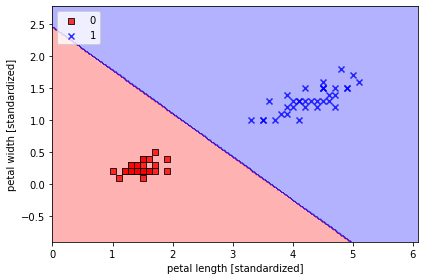

In [73]:
X_train_01_subset = X_train[(y_train == 0) | (y_train == 1)] # x_train 안에 값이 0이거나 1인 값만을 표본을 추출(iris-setosa & versicolor)
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)] # y_train 안에 값이 0이거나 1인 값만을 표본을 추출(iris-setosa & versicolor)

lrgd = LogisticRegressionGD(eta=0.05, n_iter=1000, random_state=1) # 학습률 0.05, 반복 횟수 1000의 로지스틱 회귀 객체를 생성
lrgd.fit(X_train_01_subset, # 위에서 추출한 표본으로 훈련을 시킴
         y_train_01_subset)

plot_decision_regions(X=X_train_01_subset, # 등고선맵과 산점도를 위 표본으로 그려줌.
                      y=y_train_01_subset,
                      classifier=lrgd)

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

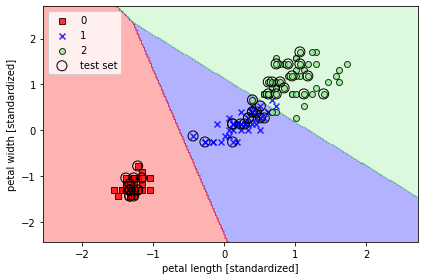

In [76]:
# 사이킷런을 이용해서 로지스틱 회귀 모델 훈련하기

"""
solver = liblinear  디폴트
multi_class = auto가 디폴트이지만 solver가 liblinear이거나 이진분류면 ovr 선택
C = 역규제 파라미터, 비용이 크면 훈련을 복잡하게, 약한 규제
random_state = 난수 생성
"""
lr = LogisticRegression(solver='liblinear', multi_class='auto', C=100.0, random_state=1)
lr.fit(X_train_std, y_train) # x 훈련 데이터 표준과 y 훈련데이터를 훈련시킴

plot_decision_regions(X_combined_std, y_combined,classifier=lr, test_index=range(105, 150)) # x_train_std와 x_test_std를 합친 데이터와 합친 y데이터를 가지고 등고선 맵과 산점도를 그림.(이전과 동일하게 테스트 데이터의 인덱스를 통해 그 데이터만 강조해서 그래프에 그림.)
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [81]:
lr.predict_proba(X_test_std[:3, :]) # 관측값에 예측값을 맞힐 확률을 나타냄, Row를 기준으로 한 줄을 더하면 1의 값이 나오는 확률을 나타냄.

array([[3.17983737e-08, 1.44886616e-01, 8.55113353e-01],
       [8.33962295e-01, 1.66037705e-01, 4.55557009e-12],
       [8.48762934e-01, 1.51237066e-01, 4.63166788e-13]])

In [86]:
lr.predict_proba(X_test_std[:3, :]).sum(axis=1) # 한줄 한줄의 총합은 확률의 합이므로 100%인 1의 값이 나옴. 

array([1., 1., 1.])

In [83]:
lr.predict_proba(X_test_std[:3, :]).argmax(axis=1) # 각 행에서 가장 큰 확률을 가지고 있는 값의 인덱스를 반환

array([2, 0, 0], dtype=int64)

In [87]:
lr.predict(X_test_std[:3, :]) # 위와 동일한 값을 반환하는 수동적인 방법

array([2, 0, 0])

In [88]:
lr.predict(X_test_std[0, :].reshape(1, -1)) # 0번째 샘플 하나의 클래스 레이블을 예측할 때 2차원 배열로 바꿔야해서 reshape함수로 변환

array([2])

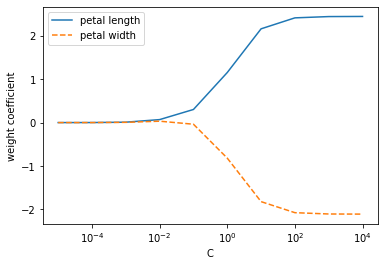

In [121]:
# 규제를 사용해 과대적합 피하기

weights, params = [], [] # 가중치, 매개변수

# -5와 5사이의 수 10개를 반복문 돌림(10회 반복)
for c in np.arange(-5, 5): 
    lr = LogisticRegression(solver='liblinear', multi_class='auto', C=10.**c, random_state=1) 
    lr.fit(X_train_std, y_train) # 표준화한 x 훈련 데이터와 y 훈련 데이터로 학습
    weights.append(lr.coef_[1]) # 가중치 목록에 명확히 구분되는 공분산 값을 넣어줌.
    params.append(10.**c) # 매개변수 목록에는 10의 규제 제곱을 한 값을 넣어줌.

    
weights = np.array(weights) # 리스트를 numpy의 배열로 변경

plt.plot(params, weights[:, 0],
         label='petal length')
plt.plot(params, weights[:, 1], linestyle='--', 
         label='petal width')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
plt.show()

## 규제가 커질수록 두개로 갈라지는 것을 확인할 수 있음. weight의 절대값이 커진다는 것을 확인.
## 규제가 너무 작으면 과소적합, 규제가 너무 크면 과대적합이므로 적합한 규제의 값을 이 그래프를 통해 찾는 것이 중요.